In [1]:
# IMPORTING LIBRARIES.
import numpy as np
import pandas as pd
import statistics as stats
import seaborn as sns
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# LOADING THE DATASET.

In [2]:
data=pd.read_excel(r'/kaggle/input/red-wine-dataset-from-uci-repository/REDWINE DATASET.xlsx')

# CREATING THE CLASS TO IMPLEMENT THE DECISION TREE.

# NODE CLASS

In [3]:
# CLASS TO STORE THE ATTRIBUTES OF THE TWO TYPES OF NODES i.e. DECISION NODE AND THE LEAF NODE.
class NODE():
    def __init__(self,feature_index=None,threshold=None,left_child=None,right_child=None,info_gain=None,value=None):
        
        # ATTRIBUTES FOR THE DECISION NODE
        self.feature_index=feature_index  # USED TO STORE WHICH FEATURE SHOULD BE CHOOSED FOR THE PARTICULAR NODE TO MINIMIZE THE INFOMATION GAIN.
        self.threshold=threshold          # USED TO CLASSIFYING VALUE OF THAT PARTICULAR FEATURE WHICH HELPS US TO MOVE THE POINT EITHER IN THE RIGHT NODE OR IN THE LEFT NODE.
        self.left_child=left_child        # TO STORE THE INFORMATION OF THE LEFT CHILD
        self.right_child=right_child      # TO STORE THE INFORMATION OF THE RIGHT CHILD
        self.info_gain=info_gain          # USED TO STORE THE GAIN OF THE BEST SPLIT 
        
        #ATTRIBUTES FOR LEAF NODE
        self.value=value
        

# CLASS TO BUILD THE DECISION TREE.

In [4]:
class TREE():
    # CONSTRUCTOR TO DEFINE THE MINIMUM NUMBER OF SAMPLES WHICH SHOULD BE THERE IN THE NODE TO MOVE TO FURTHER DEPTH AND TO DEFINE MAXIMUM DEPTH OF THE TREE.
    def __init__(self,min_samples=2,max_depth=2):
        self.root=None
        self.min_samples=min_samples
        self.max_depth=max_depth
    # FUCNTION TO BUILD THE DECISION TREE.
    def Build_Tree(self,dataset,curr_depth=0):
        # EXTRACTING THE FEATURES AND THE LABEL.
        x,y=dataset[:,:-1],dataset[:,-1]
        # FINDING THE DIMENSIONS OF THE DATASET.
        n_samples,n_features=np.shape(x)
        # CONDITION TO STOP THE RECCURSION AS THIS FUCTION IS RECCURSIVE WHICH IS USED TO GENENREATE THE TREE.
        if n_samples>=self.min_samples and curr_depth<=self.max_depth:
            # CALLING THE BEST SPLIT FUCNTION WHICH RETURENS THE DICTIONAR CONTAINING FEATURE, THRESHOLD, LEFT CHILD, RIGHT CHILD,INFORMATION GAIN FOR THE GIVEN NODE.
            best_split=self.get_best_split(dataset,n_samples,n_features)
            # APPLYING THE RECCURSIVE APPROACH TO MOVE FORWARD TO CREATED CHILD NOODES
            if best_split['info_gain']>0 :   
                          left_subtree=self.Build_Tree(best_split['dataset_left'],curr_depth+1)
                          right_subtree=self.Build_Tree(best_split['dataset_right'],curr_depth+1)
                          return NODE(best_split['feature_index'],best_split['threshold'],left_subtree,right_subtree,best_split['info_gain'])
        # RETURNING THE CLASS HAVING MAXIXMUM CONTRIBUTION IN A PARTICULAR LEAF NODE TO DETERMINE THE CLASS DURING PREDICTION OF THE TEST DATASET.                  
        leaf_value=self.calculate_leaf_value(y)
        return NODE(value=leaf_value)
    # FUNCTION WHICH IS USED TO FIND THE BEST PARAMETERS FOR THE GIVEN NODE.
    def get_best_split(self,dataset,n_samples,n_features):
        best_split={}
        # MAXIMUM VALUE IS SET TO - INFINITY SO THAT EVEN FOR THE FIRST FEATURE WE CAN SET IT AS THE BEST FEATURE.
        max_info_gain=-float('inf')
        # ITERATING OVER EACH FEATURE AND THE CALCULATING INFORMATION GAIN OF EACH THRESHOLD IN THAT FEATURE THEN AT THE END REUTNING THE DICTIONARY CONTAINING THE FEATURE AND THRESHOLD HAVING MAXIMUM INFORMATION GAIN.                  
        for feature_index in range(n_features):
            features_values=dataset[:,feature_index]
            possible_thresholds=np.unique(features_values)
                          
            for threshold in possible_thresholds:
                dataset_left,dataset_right=self.split(dataset,feature_index,threshold)
                if len(dataset_left)>0 and len(dataset_right)>0:
                    y,left_y,right_y=dataset[:,:-1] ,dataset_left[:,-1],dataset_right[:,-1]
                    curr_info_gain=self.information_gain(y,left_y,right_y,'gini')
                    if curr_info_gain>max_info_gain:
                        best_split['feature_index']=feature_index
                        best_split['threshold']=threshold
                        best_split['dataset_left']=dataset_left
                        best_split['dataset_right']=dataset_right
                        best_split['info_gain']=curr_info_gain
                        max_info_gain=curr_info_gain
                                                
        return(best_split)
    # FUNTION TO SPLIT THE DECISION NODE TO RIGHT CHILD AND LEFT CHILD FOR EACH FEATURE AND DIFFERENT THRESHOLD DURING BEST SPLIT EVALUATION.
    def split(self,dataset,feature_index,threshold):
        dataset_left=np.array([row for row in dataset if row[feature_index]<=threshold])
        dataset_right=np.array([row for row in dataset if row[feature_index]>threshold])
        return(dataset_left,dataset_right)
    # FUNCTION TO FIND THE INFORMATION GAIN TO DECIDE THE BEST SPLIT
    def information_gain(self,parent,l_child,r_child,mode='entropy'):
        # DETERMINING THE WEIGHTS OF CHILD FORMED WHICH IS (TOTAL DATAPOINTS IN CHILD NODE/ TOTAL DATAPOINT IN THE PARENT NODE).
        weight_l=len(l_child)/len(parent)
        weight_r=len(r_child)/len(parent)
        if mode=='gini':
            gain=self.gini_index(parent)-(weight_l*self.gini_index(l_child)+weight_r*self.gini_index(r_child))
        else:
            gain=self.entropy(parent)-(weight_l*self.entorpy(l_child)+weight_r*self.entorpy(r_child))
        return(gain)
    # FUCNTION TO FIND THE ENTROPY WHICH IS THE MEASURE OF MIXTURE OF CLASSES IN CHILD FORMED. IT ONE WHEN ONLY ONE CLASS IS PRESENT OR CALCULATED AS FOLLOWS.
    def entorpy(self,y):
        class_labels=np.unique(y)
        entropy=0
        for i in class_labels:
            pi=len(y[y==i])/len(y)
            entropy=entropy+np.log2(pi)
        return(entropy)
    
    # SIMILAR TO ENTROPY BUT LESS COMPUTATION POWER DUE TO ABSENCE OF LOG FUNCTION IN THE FORMULA.
    def gini_index(self,y):
        class_labels=np.unique(y)
        gini=0
        for i in class_labels:
            pi=len(y[y==i])/len(y)
            gini=gini+(pi**2)
        return 1-gini
    def calculate_leaf_value(self,y):
        y=list(y)
        return(max(y,key=y.count))
    # FUNCTION TO PASS TRAINING DATASET TO THE MODEL.
    def fit(self,x,y,dataset):

        self.root=self.Build_Tree(dataset)
    # FUNCTION TO FIND THE MODEL PREDICTIONS ON TEST DATASET.     
    def predict(self,x):
        predictions=[self.make_prediction(i,self.root) for i in x]
        return(predictions)
    # FUNCTION TO PREDICT THE CLASS OF THE DATAPOINT GIVEN.
    def make_prediction(self,x,tree):
        # THIS CONDITION IS USED TO DECIDE WEATHER A NODE IS LEAF NODE OR THE DECISON NODE AS IN THE TREE METHOD WE HAVE PASSED THE VALUE ONLY IN CASE OF LEAF NODE AND IN REST OF THE CASES IT WILL BE SET TO NONE.
        if tree.value!=None:
            return tree.value
        # IF THE NODE IS DECISION NODE THEN WE WILL BE PASSING THE DATA THROUGH THE TREE FURHTER BASED UPON THE THRESHOLD VALUE.
        feature_val=x[tree.feature_index]
        if feature_val<=tree.threshold:
            return(self.make_prediction(x,tree.left_child))
        else:
            return(self.make_prediction(x,tree.right_child))
            
                          
                          
                          
                          
    

# PREPROCESSING THE DATA AND SPLITTING IT INTO 80:20 RATIO.

In [5]:
import random
split_index=int(len(data)*0.80)

data_train=data[:split_index]
data_test=data[split_index:]
X_train=data_train.drop('quality',axis=1)
Y_train=data_train['quality']
X_test=data_test.drop('quality',axis=1)
Y_test=data_test['quality']

# NORMALIZING THE DATA WITH MAXIMUM AND MINIMUM VALUE OF THE FEATURES.

In [6]:
columns=data.drop('quality',axis=1).columns.tolist()
for i in columns:
    X_train[str(i)]=(X_train[str(i)]-min(X_train[str(i)]))/(max(X_train[str(i)])-min(X_train[str(i)]))
for i in columns:
    X_test[str(i)]=(X_test[str(i)]-min(X_test[str(i)]))/(max(X_test[str(i)])-min(X_test[str(i)]))    

   


# CREATING THE INSTANCES OF THE CLASS AND FITTING THE MODEL GO GENERATE THE TREE.

In [7]:
decision_tree=TREE(min_samples=3,max_depth=3)
decision_tree.fit(np.array(X_train),np.array(Y_train),np.array(data_train))


# PREDICTING THE QUALITY OF THE DATAPOINTS BY PASSING THROUGH THE PREVIOUSLY BUILD TREE FINDING THE ACCURACY OF THE MODEL.

In [8]:
Y_pred=decision_tree.predict(np.array(X_test))
def accuracy(Y_pred,Y_test):
    return(np.sum(Y_pred==Y_test)/len(Y_test))
print(accuracy(Y_pred,Y_test)*100)

44.6875


# VIZUALIZATION OF THE PERFORMANCE OF THE MODEL USING VARIOUS EVALUATION METRICS.

In [9]:
from sklearn.metrics import confusion_matrix
import scikitplot as skplt 
confusion_matrix=confusion_matrix(Y_pred,Y_test)
confusion_matrix

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0],
       [  5,  11, 143, 136,  22,   3],
       [  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0]])

In [10]:
PRECISION={}
RECALL={}
ACCURACY={}
F1_SCORE={}
for i in range(confusion_matrix.shape[0]):
    TP=confusion_matrix[i,i]
    FP=confusion_matrix[i,:].sum()-TP
    FN=confusion_matrix[:,i].sum()-TP
    TN=confusion_matrix.sum().sum()-TP-FP-FN
    if TP==0 and FP==0:
        ACCURACY[i]=(TP+TN)/confusion_matrix.sum().sum()
        PRECISION[i]=0
        RECALL[i]=TP/(TP+FN)
        F1_SCORE[i]=0
    else:
        ACCURACY[i]=(TP+TN)/confusion_matrix.sum().sum()
        PRECISION[i]=TP/(TP+FP)
        RECALL[i]=TP/(TP+FN)
        F1_SCORE[i]=(2*PRECISION[i]*RECALL[i])/(PRECISION[i]+RECALL[i])


In [11]:
A=ACCURACY.values()
R=RECALL.values()
P=PRECISION.values()
F1=F1_SCORE.values()

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

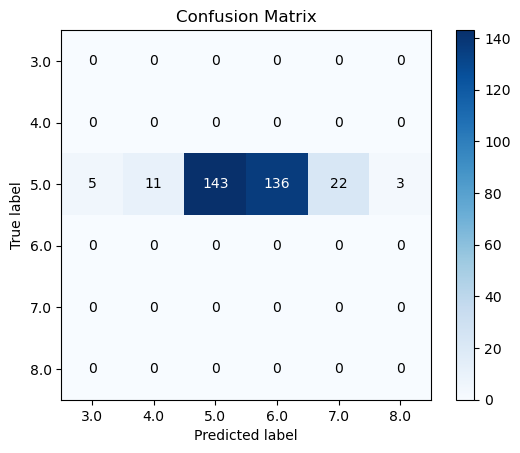

In [12]:
skplt.metrics.plot_confusion_matrix(Y_pred,Y_test)

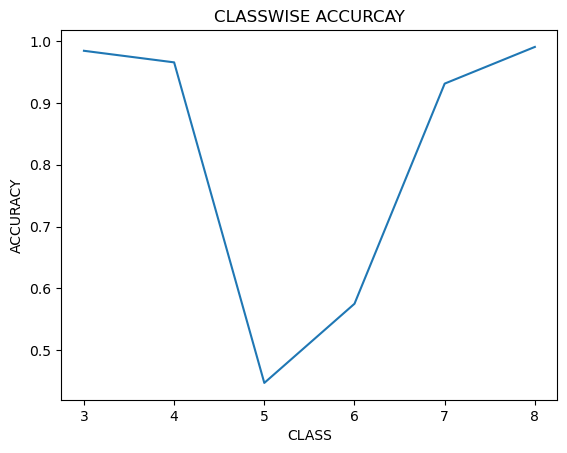

In [13]:

f,ax=plt.subplots(1)
ax.plot([3,4,5,6,7,8],np.array(list(A)))
plt.title('CLASSWISE ACCURCAY')
plt.xlabel('CLASS')
plt.ylabel('ACCURACY')
plt.show()

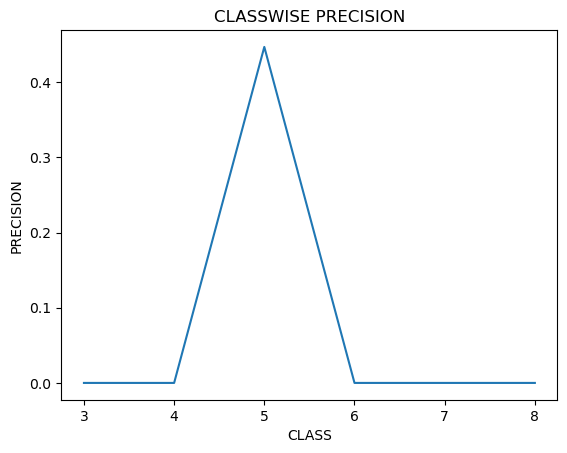

In [14]:
f,ax=plt.subplots(1)
ax.plot([3,4,5,6,7,8],np.array(list(P)))
plt.title('CLASSWISE PRECISION')
plt.xlabel('CLASS')
plt.ylabel('PRECISION')
plt.show()

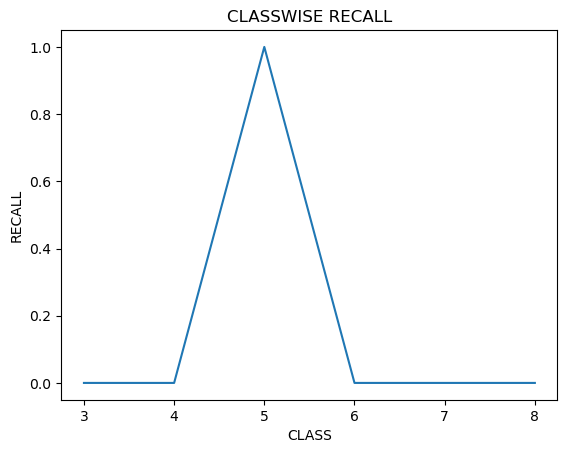

In [15]:
f,ax=plt.subplots(1)
ax.plot([3,4,5,6,7,8],np.array(list(R)))
plt.title('CLASSWISE RECALL')
plt.xlabel('CLASS')
plt.ylabel('RECALL')
plt.show()

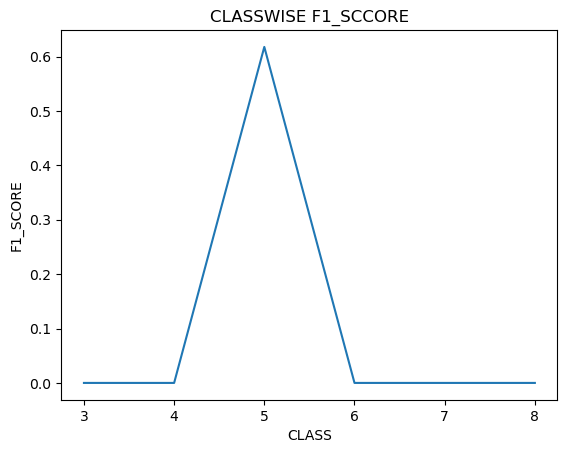

In [16]:
f,ax=plt.subplots(1)
ax.plot([3,4,5,6,7,8],np.array(list(F1)))
plt.title('CLASSWISE F1_SCCORE')
plt.xlabel('CLASS')
plt.ylabel('F1_SCORE')
plt.show()